# Add alpha factors

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR, PPO

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load MERVAL OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [82]:
DATA_STORE = './data/assets.h5'

In [83]:
YEAR = 12

In [84]:
START = 2010
END = 2024

In [85]:
with pd.HDFStore(DATA_STORE, 'r') as store:
    prices = (store['merval/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['merval/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [86]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 180246 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    180246 non-null  float64
 1   high    180246 non-null  float64
 2   low     180246 non-null  float64
 3   close   180246 non-null  float64
 4   volume  180246 non-null  float64
 5   sector  180246 non-null  object 
dtypes: float64(5), object(1)
memory usage: 8.9+ MB


In [87]:
len(prices.index.unique('ticker'))

56

## Remove stocks with less than ten years of data

In [88]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [89]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    169923 non-null  float64
 1   high    169923 non-null  float64
 2   low     169923 non-null  float64
 3   close   169923 non-null  float64
 4   volume  169923 non-null  float64
 5   sector  169923 non-null  object 
dtypes: float64(5), object(1)
memory usage: 8.4+ MB


In [90]:
len(prices.index.unique('ticker'))

50

## Add some Basic Factors

### Compute the Relative Strength Index

In [91]:
rsi = prices.groupby(level='ticker').close.apply(RSI)
prices['rsi'] = rsi.values

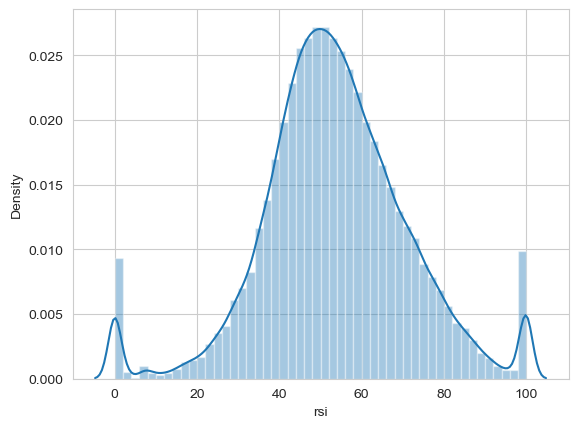

In [92]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [93]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [94]:
bb = prices.groupby(level='ticker').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_mid'] = bb['bb_mid'].values
prices['bb_low'] = bb['bb_low'].values


In [95]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   open     169923 non-null  float64
 1   high     169923 non-null  float64
 2   low      169923 non-null  float64
 3   close    169923 non-null  float64
 4   volume   169923 non-null  float64
 5   sector   169923 non-null  object 
 6   rsi      169223 non-null  float64
 7   bb_high  168973 non-null  float64
 8   bb_mid   168973 non-null  float64
 9   bb_low   168973 non-null  float64
dtypes: float64(9), object(1)
memory usage: 13.6+ MB


In [96]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,168973.000000,168973.000000,168973.000000
mean,2.704057,2.622410,2.540763
std,1.705703,1.677080,1.651122
min,0.045079,0.043175,-0.340238
25%,1.265856,1.216773,1.154697
50%,2.455401,2.362160,2.276887
75%,3.820489,3.716198,3.622759
max,10.016267,9.712113,9.587675


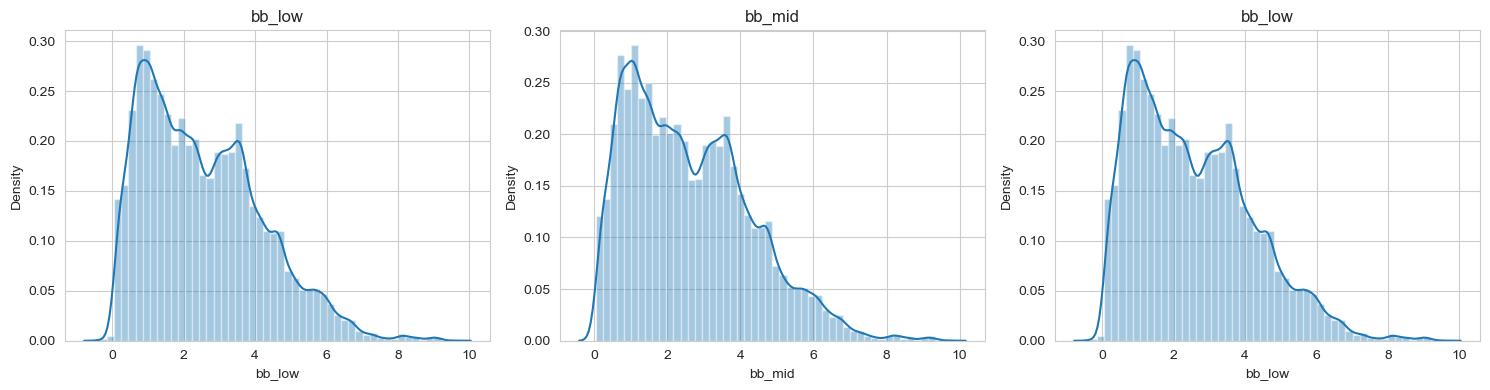

In [97]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [98]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

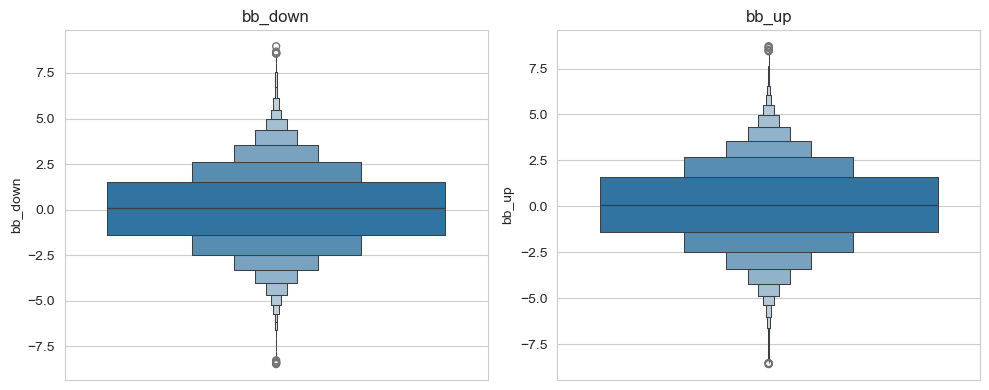

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [100]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [101]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [102]:
prices['atr'] = by_ticker.apply(compute_atr)

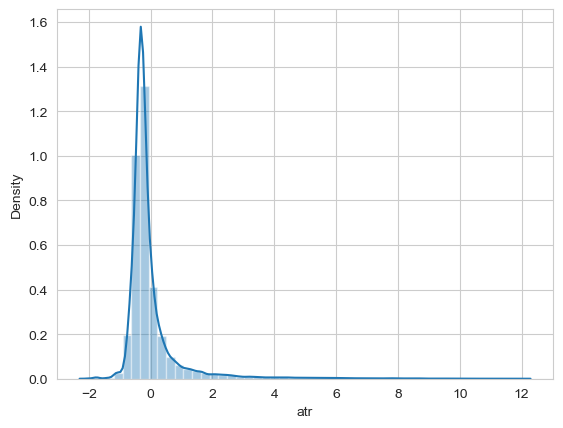

In [103]:
sns.distplot(prices.atr);

In [114]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

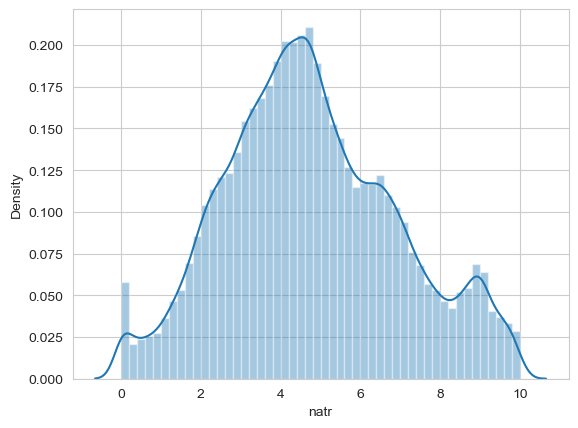

In [115]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [116]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd).values

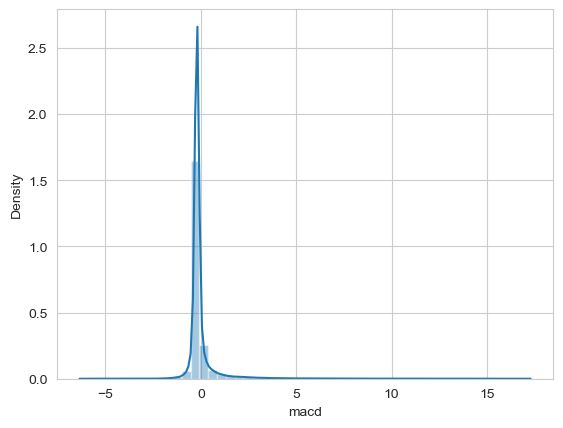

In [117]:
sns.distplot(prices.macd);

### Percentage Price Oscillator

In [118]:
prices['ppo'] = by_ticker.close.apply(PPO)

## Compute money volume to determine universe

In [119]:
prices['money_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.money_volume /= 1e6

In [120]:
prices.to_hdf('data.h5', 'merval/prices')

In [121]:
prices = pd.read_hdf('data.h5', 'merval/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   open          169923 non-null  float64
 1   high          169923 non-null  float64
 2   low           169923 non-null  float64
 3   close         169923 non-null  float64
 4   volume        169923 non-null  float64
 5   sector        169923 non-null  object 
 6   rsi           169223 non-null  float64
 7   bb_high       168973 non-null  float64
 8   bb_mid        168973 non-null  float64
 9   bb_low        168973 non-null  float64
 10  bb_up         168973 non-null  float64
 11  bb_down       168973 non-null  float64
 12  atr           169223 non-null  float64
 13  natr          169223 non-null  float64
 14  macd          168273 non-null  float64
 15  ppo           168673 non-null  float64
 16  money_vol

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [122]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['money_volume', 'volume',
                                                              'open', 'high', 'low']]

In [123]:
prices = prices.unstack('ticker')

In [124]:
data = (pd.concat([prices.money_volume.resample('M').mean().stack('ticker').to_frame('money_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8312 entries, ('ALUA.BA', Timestamp('2010-02-28 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  8312 non-null   float64
 1   atr           8312 non-null   float64
 2   bb_down       8312 non-null   float64
 3   bb_high       8312 non-null   float64
 4   bb_low        8312 non-null   float64
 5   bb_mid        8312 non-null   float64
 6   bb_up         8312 non-null   float64
 7   close         8312 non-null   float64
 8   macd          8312 non-null   float64
 9   natr          8312 non-null   float64
 10  ppo           8312 non-null   float64
 11  rsi           8312 non-null   float64
 12  sector        8312 non-null   object 
dtypes: float64(12), object(1)
memory usage: 876.5+ KB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [126]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [127]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8262 entries, ('ALUA.BA', Timestamp('2010-03-31 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   8262 non-null   float64
 1   return_3m   8162 non-null   float64
 2   return_6m   8012 non-null   float64
 3   return_12m  7712 non-null   float64
dtypes: float64(4)
memory usage: 286.2+ KB


In [128]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,8262.000000,8162.000000,8012.000000,7712.000000
mean,0.047560,0.038517,0.036020,0.032873
std,0.158623,0.089248,0.062915,0.047866
min,-0.282891,-0.155587,-0.099148,-0.070951
25%,-0.048909,-0.019412,-0.006248,0.000000
50%,0.015036,0.023264,0.027725,0.029402
75%,0.117463,0.087380,0.074623,0.062708
max,0.631940,0.328090,0.220220,0.168727


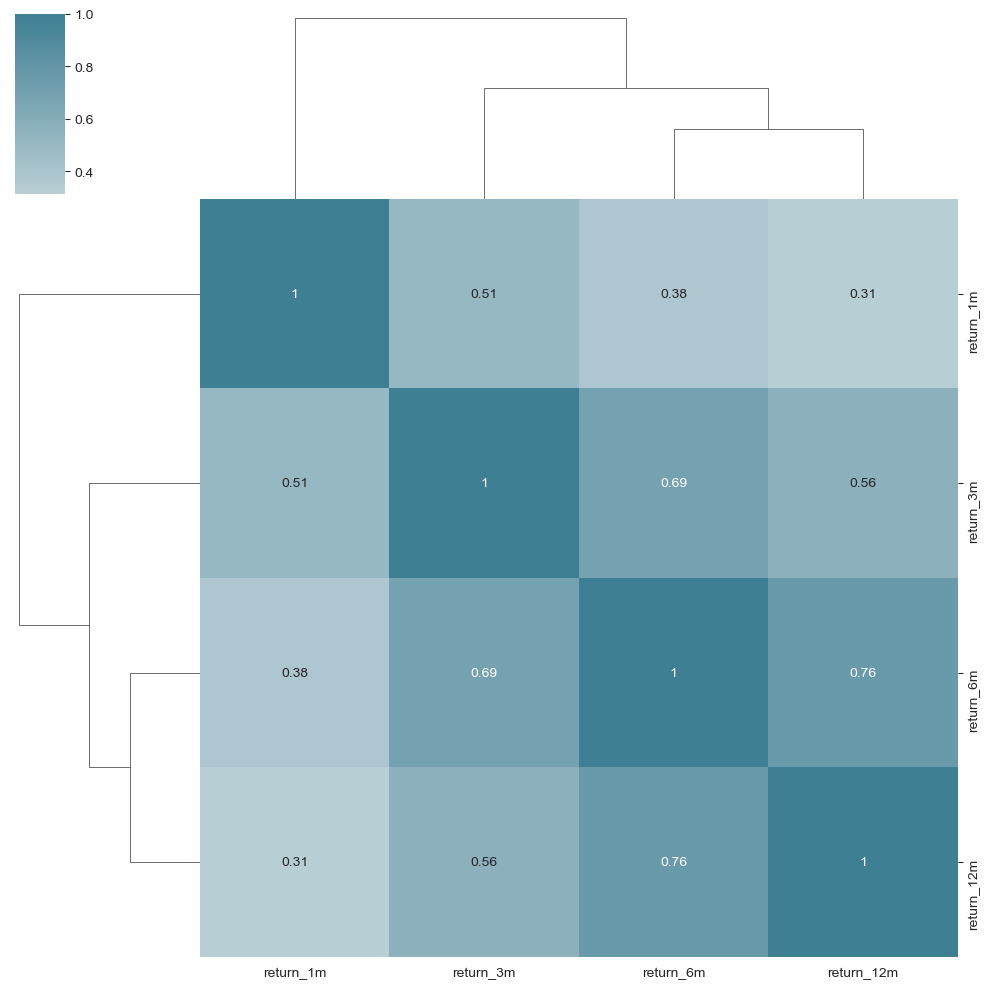

In [129]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [130]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7712 entries, ('ALUA.BA', Timestamp('2011-02-28 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  7712 non-null   float64
 1   atr           7712 non-null   float64
 2   bb_down       7712 non-null   float64
 3   bb_high       7712 non-null   float64
 4   bb_low        7712 non-null   float64
 5   bb_mid        7712 non-null   float64
 6   bb_up         7712 non-null   float64
 7   macd          7712 non-null   float64
 8   natr          7712 non-null   float64
 9   ppo           7712 non-null   float64
 10  rsi           7712 non-null   float64
 11  sector        7712 non-null   object 
 12  return_1m     7712 non-null   float64
 13  return_3m     7712 non-null   float64
 14  return_6m     7712 non-null   float64
 15  return_12m    7712 non-null   float64
dtypes: float64(15), object(1)
mem

In [131]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [132]:
tickers_left = len(data.index.unique('ticker'))
f"the result is {tickers_left} tickers"

'the result is 50 tickers'

## Rolling Factor Betas

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

We can use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [133]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 2010-01-31 to 2024-04-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  172 non-null    float64
 1   SMB     172 non-null    float64
 2   HML     172 non-null    float64
 3   RMW     172 non-null    float64
 4   CMA     172 non-null    float64
dtypes: float64(5)
memory usage: 8.1 KB


In [134]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7712 entries, ('ALUA.BA', Timestamp('2011-02-28 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     7712 non-null   float64
 1   SMB        7712 non-null   float64
 2   HML        7712 non-null   float64
 3   RMW        7712 non-null   float64
 4   CMA        7712 non-null   float64
 5   return_1m  7712 non-null   float64
dtypes: float64(6)
memory usage: 390.0+ KB


In [135]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000
mean,0.010087,-0.000784,-0.000978,0.003179,0.000194,0.035996
std,0.043595,0.026617,0.033506,0.020262,0.021550,0.154338
min,-0.133900,-0.082800,-0.138700,-0.047500,-0.072200,-0.347491
25%,-0.015500,-0.018900,-0.018300,-0.012200,-0.013600,-0.060500
50%,0.012700,-0.000600,-0.003700,0.003000,-0.000800,0.007367
75%,0.034400,0.015700,0.013800,0.015600,0.012400,0.104632
max,0.136500,0.073200,0.127500,0.072000,0.077200,0.669640


In [136]:
T = 60
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [137]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,7712.000000
mean,0.054396,-0.382375,0.045279,-0.011113,0.141715,-0.093917
std,0.629510,0.835875,0.852303,1.106388,1.350017,1.474412
min,-2.180037,-3.525774,-2.734890,-3.701034,-4.459247,-7.412231
25%,-0.317757,-0.888483,-0.491942,-0.725275,-0.767123,-0.597687
50%,0.078750,-0.320244,0.059878,-0.018743,0.150254,0.000000
75%,0.470021,0.143951,0.580413,0.761371,1.043115,0.286354
max,1.896692,3.290480,3.808949,3.587107,4.458655,6.141010


In [138]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,7712.000000
mean,0.054396,-0.382375,0.045279,-0.011113,0.141715,-0.093917
std,0.629510,0.835875,0.852303,1.106388,1.350017,1.474412
min,-2.180037,-3.525774,-2.734890,-3.701034,-4.459247,-7.412231
25%,-0.317757,-0.888483,-0.491942,-0.725275,-0.767123,-0.597687
50%,0.078750,-0.320244,0.059878,-0.018743,0.150254,0.000000
75%,0.470021,0.143951,0.580413,0.761371,1.043115,0.286354
max,1.896692,3.290480,3.808949,3.587107,4.458655,6.141010


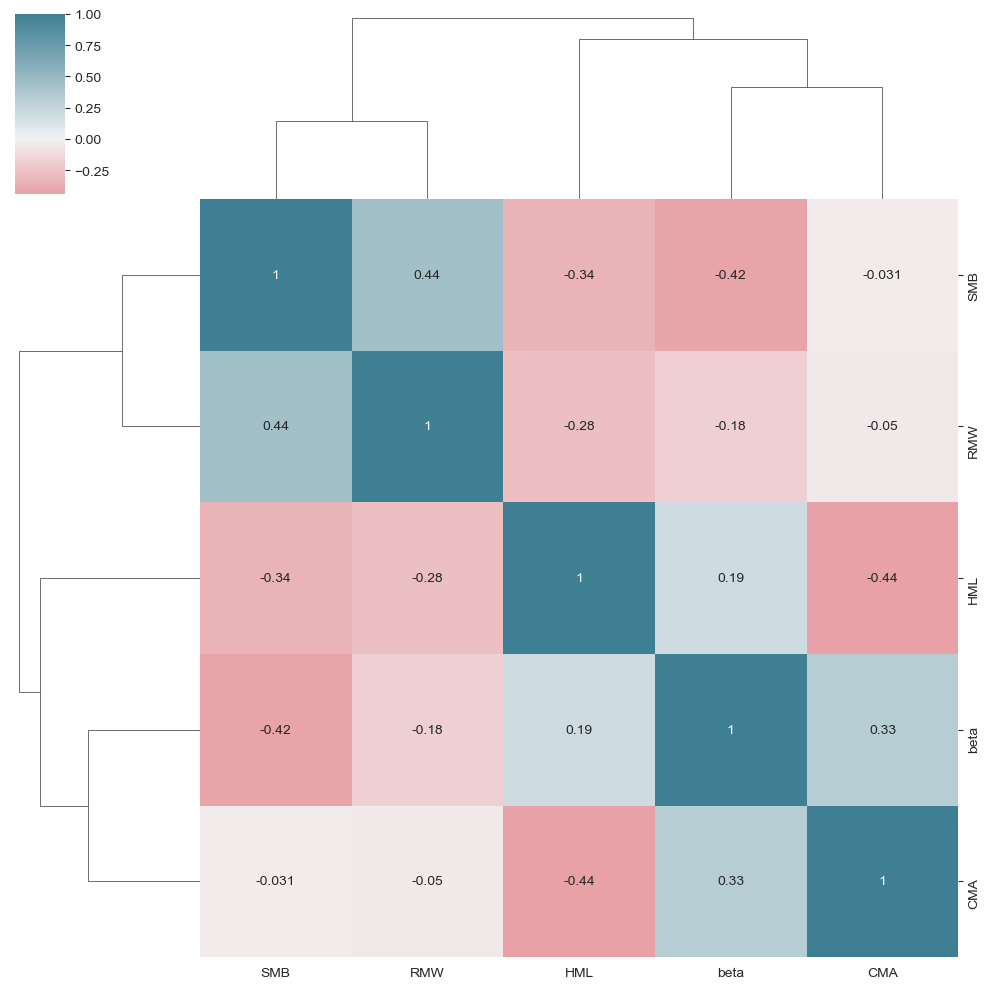

In [139]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [140]:
data = (data
      .join(betas
          .groupby(level='ticker')
          .shift())
     .dropna()
     .sort_index())

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4712 entries, ('ALUA.BA', Timestamp('2016-02-29 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  4712 non-null   float64
 1   atr           4712 non-null   float64
 2   bb_down       4712 non-null   float64
 3   bb_high       4712 non-null   float64
 4   bb_low        4712 non-null   float64
 5   bb_mid        4712 non-null   float64
 6   bb_up         4712 non-null   float64
 7   macd          4712 non-null   float64
 8   natr          4712 non-null   float64
 9   ppo           4712 non-null   float64
 10  rsi           4712 non-null   float64
 11  sector        4712 non-null   object 
 12  return_1m     4712 non-null   float64
 13  return_3m     4712 non-null   float64
 14  return_6m     4712 non-null   float64
 15  return_12m    4712 non-null   float64
 16  beta          4712 non-null  

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [142]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [143]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [144]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [145]:
data = data.dropna()

In [146]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4662 entries, ('ALUA.BA', Timestamp('2016-02-29 00:00:00')) to ('YPFD.BA', Timestamp('2023-11-30 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   money_volume   4662 non-null   float64
 1   atr            4662 non-null   float64
 2   bb_down        4662 non-null   float64
 3   bb_high        4662 non-null   float64
 4   bb_low         4662 non-null   float64
 5   bb_mid         4662 non-null   float64
 6   bb_up          4662 non-null   float64
 7   macd           4662 non-null   float64
 8   natr           4662 non-null   float64
 9   ppo            4662 non-null   float64
 10  rsi            4662 non-null   float64
 11  sector         4662 non-null   object 
 12  return_1m      4662 non-null   float64
 13  return_3m      4662 non-null   float64
 14  return_6m      4662 non-null   float64
 15  return_12m     4662 non-null   float64
 16  beta       

## Sector Breakdown

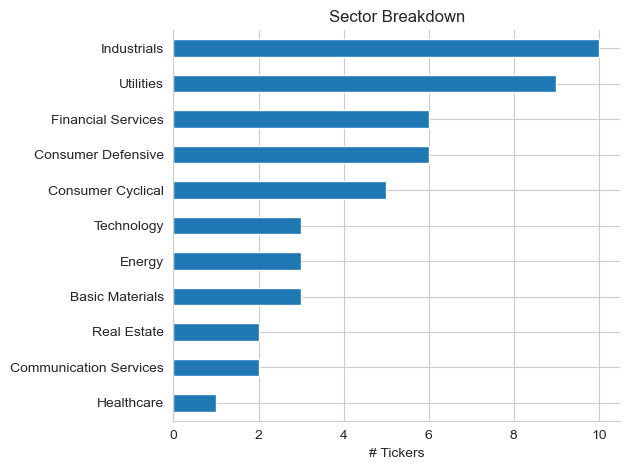

In [147]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [148]:
with pd.HDFStore('data.h5') as store:
    store.put('merval/monthly', data)

## Evaluate mutual information

In [149]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [150]:
mi = mutual_info_regression(X=X, y=data.target)

In [151]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

bb_mid          0.159738
bb_high         0.156891
bb_low          0.149957
return_6m       0.082187
ppo             0.079846
year            0.073969
return_12m      0.070438
money_volume    0.068177
atr             0.067728
return_1m       0.063589
dtype: float64

In [152]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [153]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

bb_high         0.107032
bb_mid          0.095954
bb_low          0.093090
rsi             0.039449
return_12m      0.020907
month           0.020040
ppo             0.017558
macd            0.017009
year            0.016986
money_volume    0.016023
dtype: float64

In [154]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [155]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

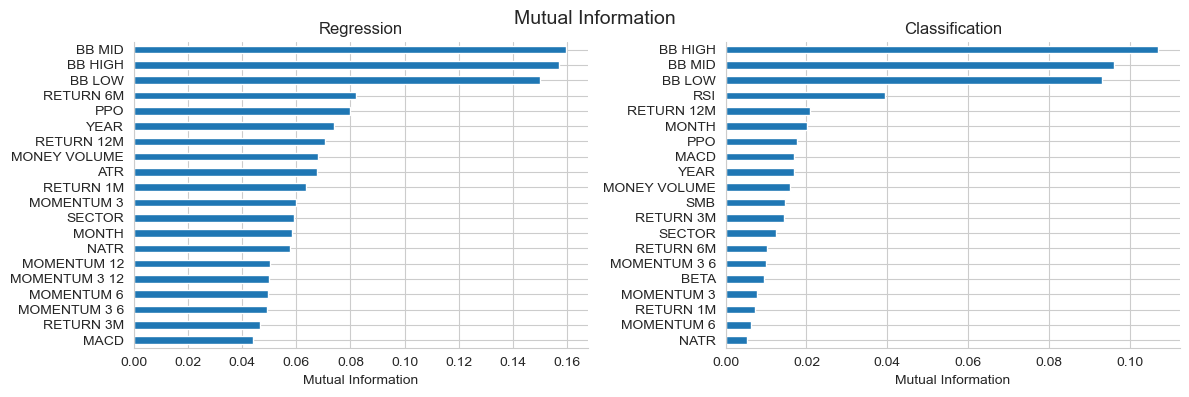

In [156]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

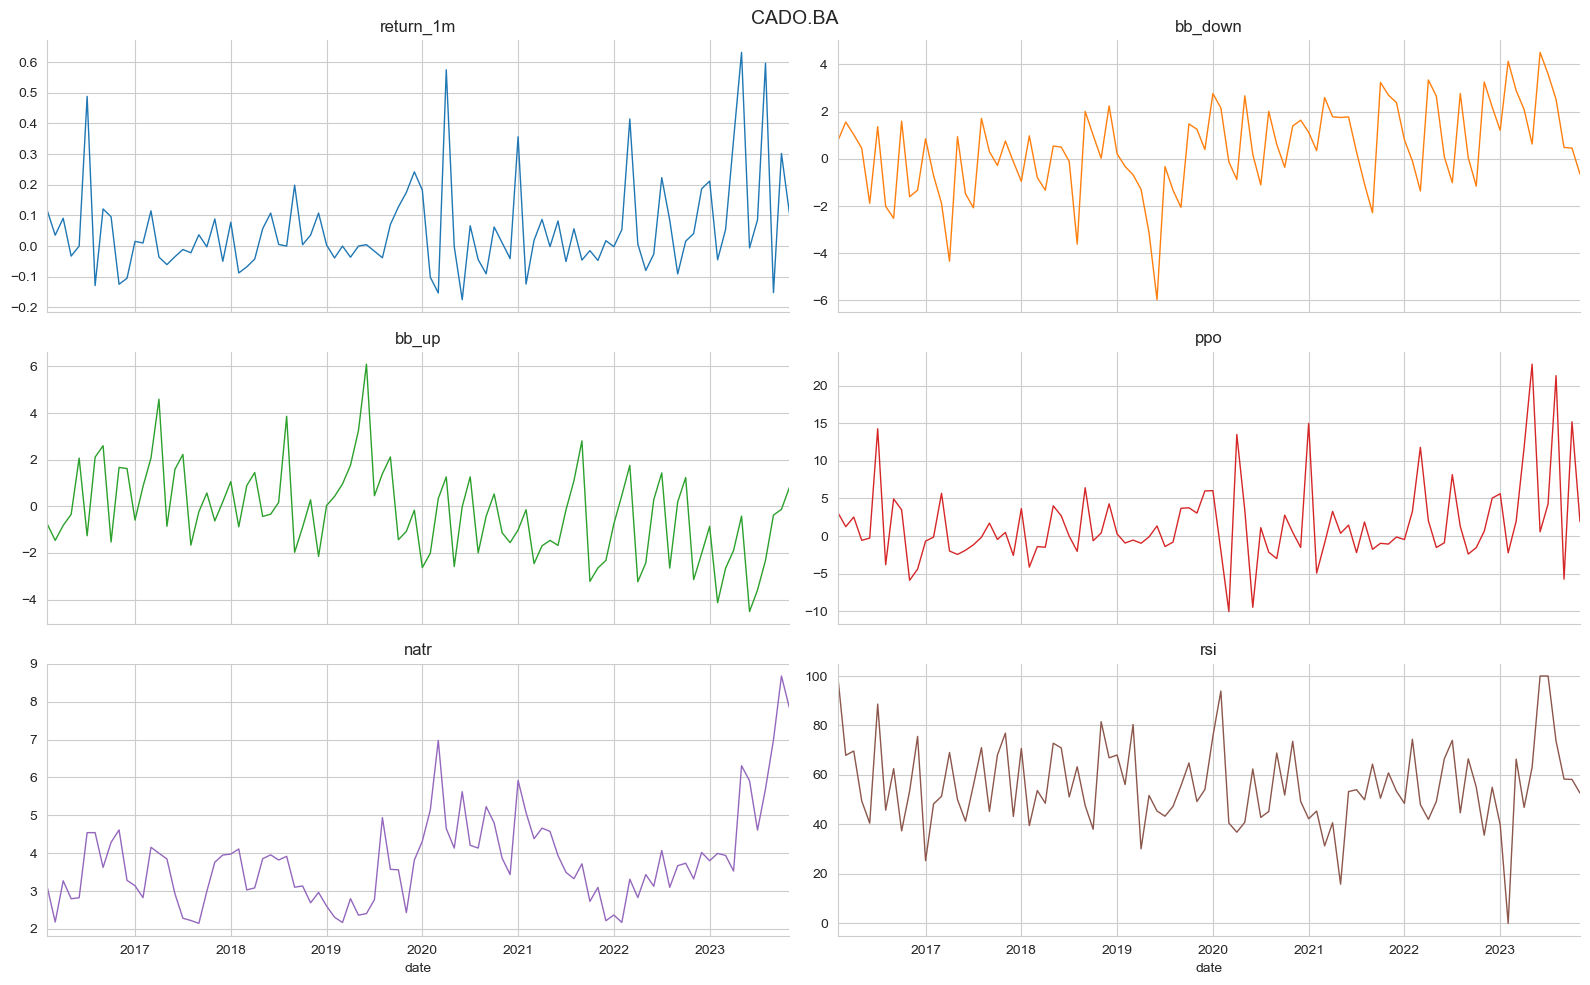

In [158]:
indicators = ['return_1m', 'bb_down', 'bb_up', 'ppo', 'natr', 'rsi']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)